In [1]:
# Importieren der benötigten Bibliotheken

# Datenmanipulation
import pandas as pd

# Visualisierung
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

# Warnings unterdrücken
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action="ignore", category=DataConversionWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

# Baseline Modellierung


In [2]:
# Einlesen der Trainings- und Testdaten
destination_path = "../data/processed"

features_train = pd.read_csv(f"{destination_path}/features_train.csv")
features_test = pd.read_csv(f"{destination_path}/features_test.csv")
target_train = pd.read_csv(f"{destination_path}/target_train.csv")
target_test = pd.read_csv(f"{destination_path}/target_test.csv")

# Zielvariable in einem dict organisieren
targets = {
    "compressor": {
        "train": target_train.iloc[:, 0],
        "test": target_test.iloc[:, 0]
    },
    "turbine": {
        "train": target_train.iloc[:, 1],
        "test": target_test.iloc[:, 1]
    }
}

In [3]:
# Piplines für verschiedene Modelle
pipeline_lr = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
pipeline_rf = Pipeline([("model", RandomForestRegressor(random_state=42))])
pipeline_dt = Pipeline([("model", DecisionTreeRegressor(random_state=42))])

# Modelle in einem Dictionary organisieren
models = {
    "Linear Regression": pipeline_lr,
    "Random Forest": pipeline_rf,
    "Decision Tree": pipeline_dt
}

In [4]:
# Evaluierung der Baseline-Modelle mit allen Features
all_results = []

# Schleife für Kompressor und Turbine
for target_name, target_data in targets.items():
    # Split der Zielvariable in Trainings- und Testdaten
    target_train_data = target_data["train"]
    target_test_data = target_data["test"]
    
    # Schleife über alle Modelle
    for model_name, model_pipeline in models.items():
        current_model = clone(model_pipeline) # Klonen des Modells
        current_model.fit(features_train, target_train_data) # Training des Modells
        target_pred = current_model.predict(features_test) # Vorhersage auf den Testdaten
        
        # Berechnung der Metriken
        r2 = r2_score(target_test_data, target_pred)
        mae = mean_absolute_error(target_test_data, target_pred)
        mse = mean_squared_error(target_test_data, target_pred)
        
        # Speichern der Ergebnisse
        results = {"Target": target_name, "Model": model_name, "R2": r2, "MAE": mae, "MSE": mse}
        all_results.append(results)

# Speichern der Ergebnisse in einer CSV-Datei
results_df = pd.DataFrame(all_results)
results_df.to_csv("../data/results/baseline_results.csv", index=False)

print("Baseline Modellergebnisse")
print(results_df.round(4))

Baseline Modellergebnisse
       Target              Model      R2     MAE  MSE
0  compressor  Linear Regression  0.8383  0.0046  0.0
1  compressor      Random Forest  0.9956  0.0006  0.0
2  compressor      Decision Tree  0.9886  0.0010  0.0
3     turbine  Linear Regression  0.9072  0.0017  0.0
4     turbine      Random Forest  0.9910  0.0004  0.0
5     turbine      Decision Tree  0.9800  0.0005  0.0


# Model Interpretation (Feature Importance)


In [5]:
# Trainiere für jedes Target ein RandomForest-Modell mit allen Features
feature_names = features_train.columns
importance_dfs = {}

# Schleife für Kompressor und Turbine
for target_name, target_data in targets.items():
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # Initialisiere das Modell
    rf_model.fit(features_train, target_data['train']) # Trainiere das Modell
    
    # Extrahiere die Feature Importances
    importances = rf_model.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_dfs[target_name] = importance_df.sort_values(by="Importance", ascending=False)

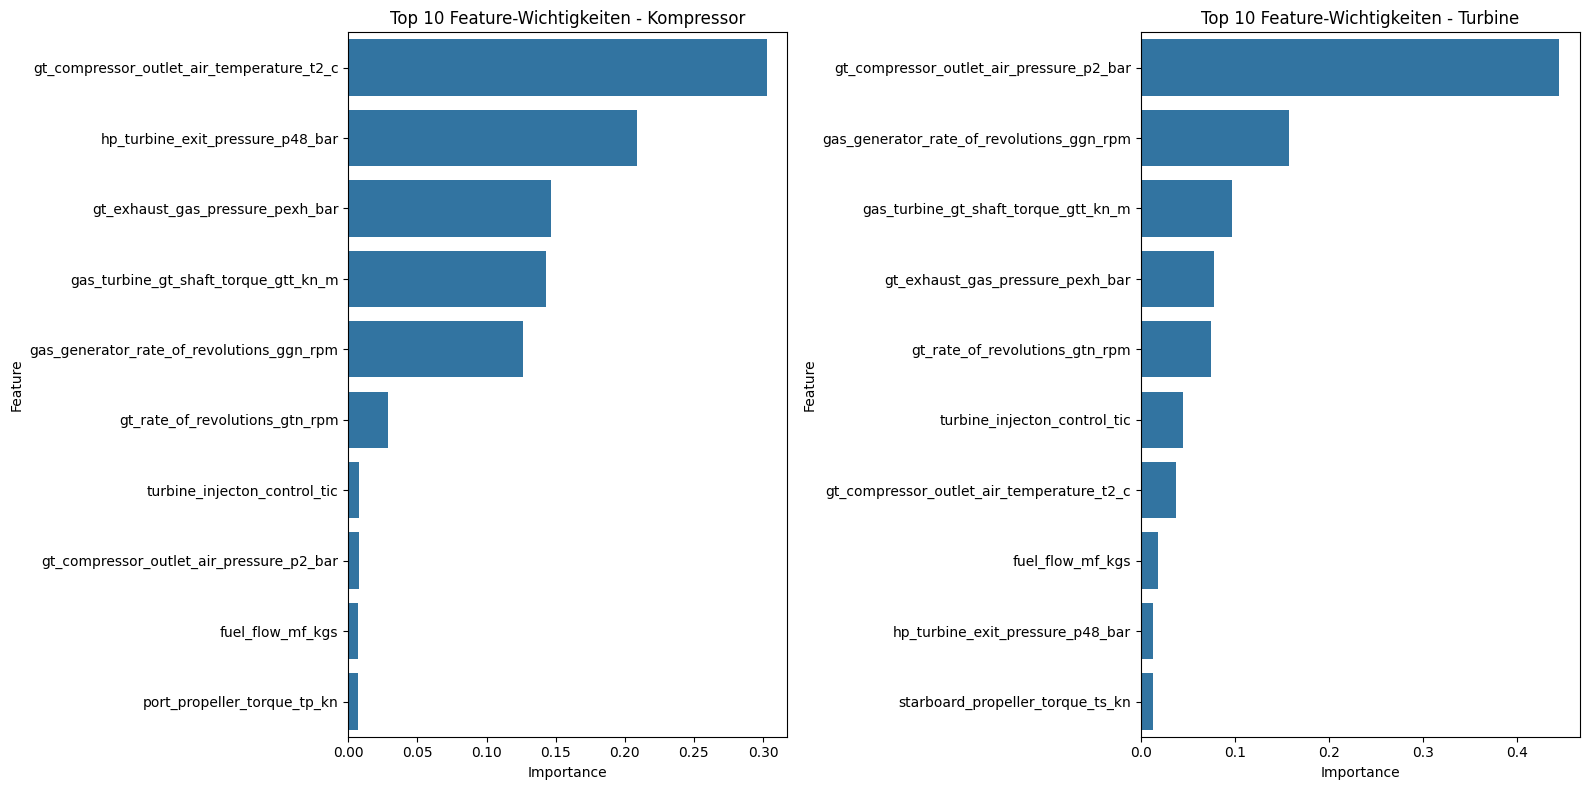

In [6]:
# Visualisierung der Feature-Wichtigkeiten
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot für Kompressor
sns.barplot(x="Importance", y="Feature", data=importance_dfs['compressor'].head(10), ax=axes[0])
axes[0].set_title("Top 10 Feature-Wichtigkeiten - Kompressor")

# Plot für Turbine
sns.barplot(x="Importance", y="Feature", data=importance_dfs['turbine'].head(10), ax=axes[1])
axes[1].set_title("Top 10 Feature-Wichtigkeiten - Turbine")

plt.tight_layout()
plt.show()